In [12]:
# Imports and logging

import os
import sys
import logging
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

logging.basicConfig(
    level=logging.INFO,
    format='%(levelname)s: %(message)s',
    stream=sys.stdout,
    force=True
)
logger = logging.getLogger(__name__)
logger.info("Logging initialized")


INFO: Logging initialized


In [13]:
# Set device, load model and processor

def get_device():
    # Get device based on cuda support
    device = "cuda" if torch.cuda.is_available() else "cpu"
    logger.info(f"Device: {device}")
    if torch.cuda.is_available():
        logger.info(f"GPU: {torch.cuda.get_device_name(0)}")
        logger.info(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    return device

def load_model(model_name, device):
    # Download and load model and processor
    logger.info(f"Loading {model_name}...")
    model = CLIPModel.from_pretrained(model_name).to(device)
    processor = CLIPProcessor.from_pretrained(model_name)
    logger.info(f"Loaded {model_name}")

    return model, processor

# Get the device to use
device = get_device()

# Load model and processor
model_name = "openai/clip-vit-base-patch32"
model, processor= load_model(model_name, device)


INFO: Device: cuda
INFO: GPU: NVIDIA GeForce RTX 3060 Ti
INFO: VRAM: 8.2 GB
INFO: Loading openai/clip-vit-base-patch32...
INFO: Loaded openai/clip-vit-base-patch32


In [14]:
# Load saved embeddings data from .h5 file

def load_embeddings(filepath: str) -> dict:
    logger.info(f"Loading embeddings from {filepath}...")
    
    with h5py.File(filepath, 'r') as f:
        # Verify structure
        required_keys = {'image_embeddings', 'text_embeddings', 'image_names', 'captions'}
        if not required_keys.issubset(f.keys()):
            raise ValueError(f"Missing required datasets in {filepath}")
        
        # Load all data
        embeddings_data = {
            'image_embeddings': f['image_embeddings'][:],
            'text_embeddings': f['text_embeddings'][:],
            'image_names': [name.decode('utf-8') for name in f['image_names'][:]], 
            'captions': [cap.decode('utf-8') for cap in f['captions'][:]], 
            'metadata': dict(f.attrs)
        }
        
        # Verify images path exists in metadata
        images_path = embeddings_data['metadata'].get('images_path', '')
        if not images_path:
            raise ValueError("Images path not found in metadata")
        
        # Verify images path exists
        if not os.path.exists(images_path):
            raise FileNotFoundError(f"Images directory not found: {images_path}")
    
    logger.info(f"Loaded {len(embeddings_data['image_names'])} embedding pairs")
    logger.info(f"Images path from metadata: {images_path}")
    return embeddings_data

# Load embeddings
embeddings_data = load_embeddings("data/flickr8k_embeddings.h5")

INFO: Loading embeddings from data/flickr8k_embeddings.h5...
INFO: Loaded 40455 embedding pairs
INFO: Images path from metadata: /home/capacap/Projects/search_engine_demo/data/datasets/adityajn105/flickr8k/versions/1/Images


In [15]:
# Utility function for displaying search results in the notebook

def display_search_results(results: list, images_path: str):
    """Display search results with images"""
    for result in results:
        logger.info(f"Rank {result['rank']}: {result['image_name']}")
        logger.info(f"Similarity: {result['similarity_score']:.3f}")
        logger.info(f"Caption: {result['caption']}")
        
        # Display image if available
        image_path = os.path.join(images_path, result['image_name'])
        if os.path.exists(image_path):
            img = Image.open(image_path)
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.title(f"Rank {result['rank']}: {result['image_name']}")
            plt.axis('off')
            plt.show()
        
        logger.info("-" * 50)


INFO: Searching for: 'a dog playing in the park'
INFO: Rank 1: 3540416139_c884f38351.jpg
INFO: Similarity: 0.342
INFO: Caption: A dog playing outside in the grass .


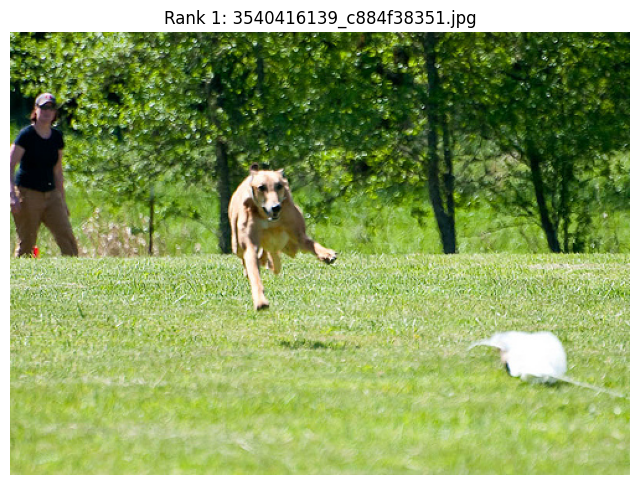

INFO: --------------------------------------------------
INFO: Rank 2: 3540416139_c884f38351.jpg
INFO: Similarity: 0.342
INFO: Caption: A dog chases a toy in the grass with its owner in the background .


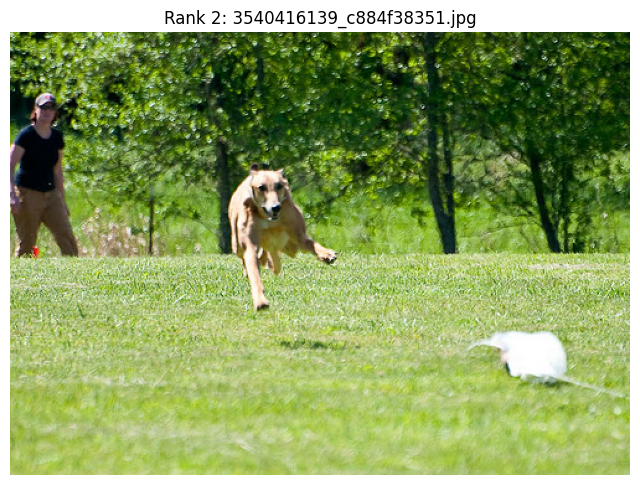

INFO: --------------------------------------------------
INFO: Rank 3: 3540416139_c884f38351.jpg
INFO: Similarity: 0.342
INFO: Caption: The brown dog is running outside on the grass .


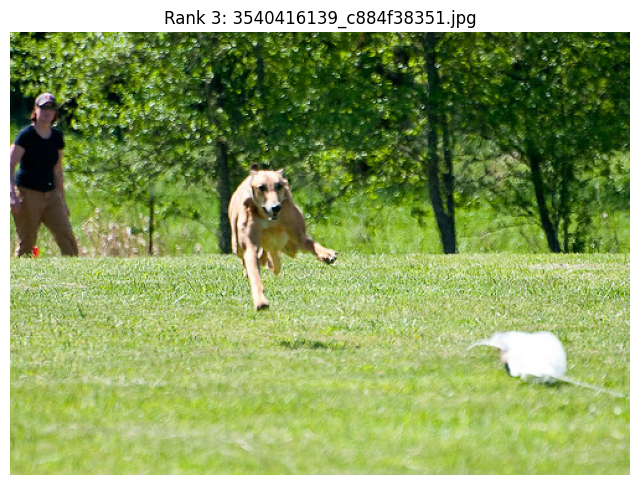

INFO: --------------------------------------------------
INFO: Rank 4: 3540416139_c884f38351.jpg
INFO: Similarity: 0.342
INFO: Caption: A golden dog is running across the grass chasing a white toy on the ground .


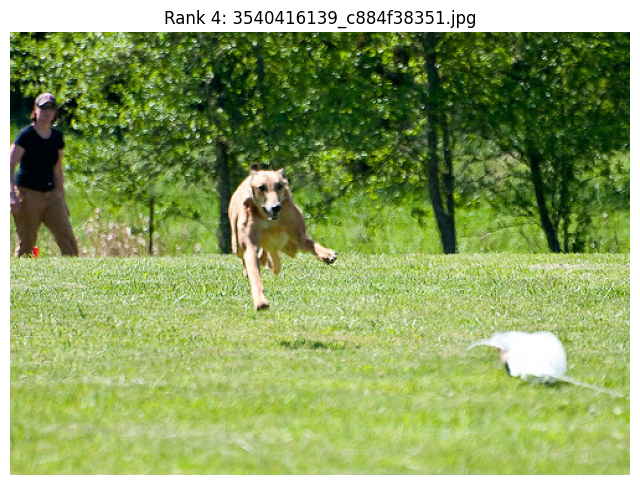

INFO: --------------------------------------------------
INFO: Rank 5: 3540416139_c884f38351.jpg
INFO: Similarity: 0.342
INFO: Caption: A dog chases a white animal on a green lawn .


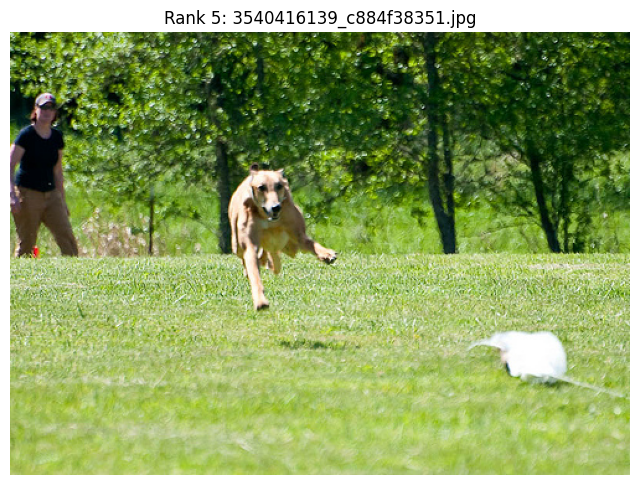

INFO: --------------------------------------------------


In [16]:
# Search the database using a text query

def search_images_by_text(
    query_text: str, 
    embeddings_data: dict, 
    model, 
    processor, 
    device, 
    top_k: int = 5
    ) -> list:    
    # Embed the query text
    text_inputs = processor(
        text=query_text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=77
        ).to(device)
    
    # Normalize the query text embedding
    with torch.no_grad():
        query_embedding = model.get_text_features(**text_inputs)
        query_embedding = query_embedding.cpu().numpy()
        query_norm = query_embedding / np.linalg.norm(query_embedding)
    
    # The core mathematical operation - cosine similarity via dot product
    image_embeddings = np.array(embeddings_data['image_embeddings'])  # Embeddings are already normalized
    similarities = image_embeddings @ query_norm.T
    similarities = similarities.flatten()
    
    # Get top-k most similar images
    top_indices = np.argpartition(similarities, -top_k)[-top_k:]
    top_indices = top_indices[np.argsort(similarities[top_indices])][::-1]
    
    # Format results
    results = []
    for idx in top_indices:
        results.append({
            'image_name': embeddings_data['image_names'][idx],
            'caption': embeddings_data['captions'][idx],
            'similarity_score': float(similarities[idx]),
            'rank': len(results) + 1
        })
    
    return results

# Search with example query

query = "a dog playing in the park"
logger.info(f"Searching for: '{query}'")
results = search_images_by_text(
    query_text=query,
    embeddings_data=embeddings_data,
    model=model,
    processor=processor, 
    device=device,
    top_k=5
)

# Display results
images_path = embeddings_data['metadata']['images_path']
display_search_results(results, images_path)


INFO: Searching for: 'a dog playing in the park'
INFO: Rank 1: 3540416139_c884f38351.jpg
INFO: Similarity: 0.342
INFO: Caption: A dog chases a toy in the grass with its owner in the background .


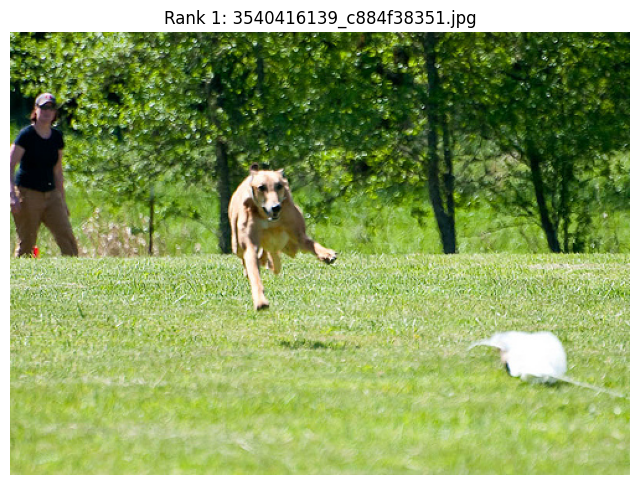

INFO: --------------------------------------------------
INFO: Rank 2: 2297471897_3419605c16.jpg
INFO: Similarity: 0.336
INFO: Caption: a dog playing ouside


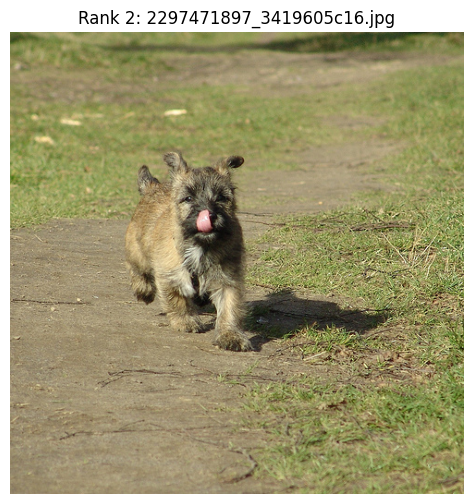

INFO: --------------------------------------------------
INFO: Rank 3: 763577068_4b96ed768b.jpg
INFO: Similarity: 0.332
INFO: Caption: A dog on the heels of a man .


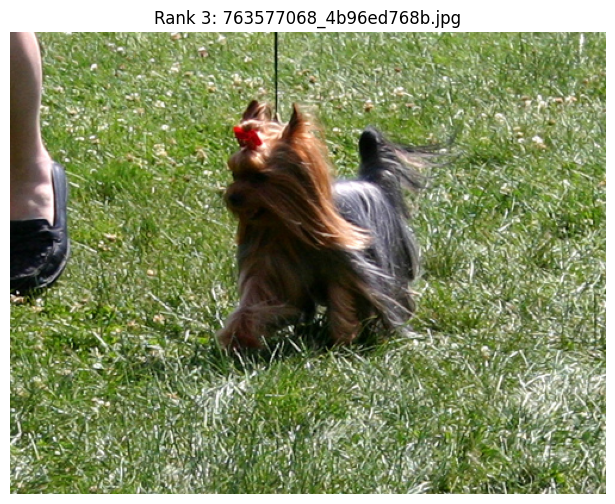

INFO: --------------------------------------------------
INFO: Rank 4: 454691853_cc1e0fa6a1.jpg
INFO: Similarity: 0.330
INFO: Caption: A dog carries a leash in its mouth .


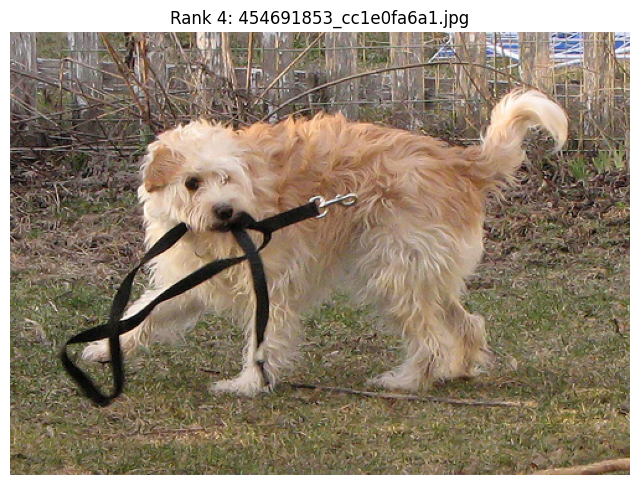

INFO: --------------------------------------------------
INFO: Rank 5: 3412036192_d8cd12ed3f.jpg
INFO: Similarity: 0.328
INFO: Caption: A brown and white dog is jumping up to catch a ball in the park .


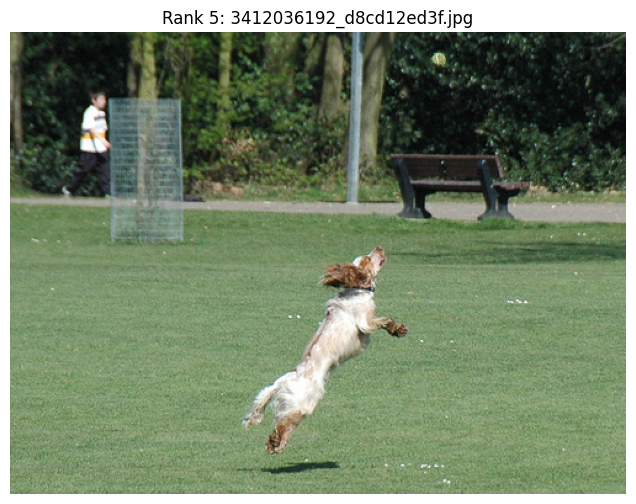

INFO: --------------------------------------------------


In [17]:
# Search the database using a text query, but an image can only appear once in the results

def search_images_by_text_diverse(
    query_text: str, 
    embeddings_data: dict, 
    model, 
    processor, 
    device, 
    top_k: int = 5
    ) -> list:
    # Embed the query text
    text_inputs = processor(
        text=query_text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=77
        ).to(device)
    
    # Normalize the query text embedding
    with torch.no_grad():
        query_embedding = model.get_text_features(**text_inputs)
        query_embedding = query_embedding.cpu().numpy()
        query_norm = query_embedding / np.linalg.norm(query_embedding)
    
    # The core mathematical operation - cosine similarity via dot product
    image_embeddings = np.array(embeddings_data['image_embeddings']) # Embeddings are already normalized
    similarities = image_embeddings @ query_norm.T
    similarities = similarities.flatten()
    
    # Group by image and find best caption for each
    image_best_matches = {}
    for idx, similarity in enumerate(similarities):
        image_name = embeddings_data['image_names'][idx]
        caption = embeddings_data['captions'][idx]
        
        # Keep the caption with highest similarity for each unique image
        if image_name not in image_best_matches or similarity > image_best_matches[image_name]['similarity']:
            image_best_matches[image_name] = {
                'similarity': similarity,
                'caption': caption,
                'index': idx
            }
    
    # Sort unique images by their best similarity scores
    unique_results = []
    for image_name, match_data in image_best_matches.items():
        unique_results.append({
            'image_name': image_name,
            'caption': match_data['caption'],
            'similarity_score': float(match_data['similarity']),
            'index': match_data['index']
        })
    
    # Sort final selection by score
    unique_results.sort(key=lambda x: x['similarity_score'], reverse=True)
    
    # Add ranking data
    for i, result in enumerate(unique_results[:top_k]):
        result['rank'] = i + 1
    
    return unique_results[:top_k]

# Search with example query - no duplicate images

logger.info(f"Searching for: '{query}'")
results = search_images_by_text_diverse(
    query_text=query,
    embeddings_data=embeddings_data,
    model=model,
    processor=processor, 
    device=device,
    top_k=5
)

# Display results
images_path = embeddings_data['metadata']['images_path']
display_search_results(results, images_path)